<a href="https://colab.research.google.com/github/amartsin/Speech-Recognition-using-CNN/blob/main/SpeechRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"amartyabhattacharya","key":"f02ad05a9529ab6264d5f9b8b18cb7bd"}'}

In [ ]:

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c tensorflow-speech-recognition-challenge

  0% 0.00/50.0 [00:00<?, ?B/s]
100% 50.0/50.0 [00:00<00:00, 83.1kB/s]
100% 2.45G/2.46G [00:34<00:00, 37.8MB/s]
100% 2.46G/2.46G [00:34<00:00, 76.3MB/s]
  0% 0.00/501k [00:00<?, ?B/s]
100% 501k/501k [00:00<00:00, 158MB/s]
100% 1.04G/1.04G [00:27<00:00, 47.7MB/s]
100% 1.04G/1.04G [00:28<00:00, 39.9MB/s]


In [ ]:
!apt-get install p7zip-full
!p7zip -d train.7z

Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-6).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.

7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 1121103842 bytes (1070 MiB)

Extracting archive: train.7z
--
Path = train.7z
Type = 7z
Physical Size = 1121103842
Headers Size = 389133
Method = Delta LZMA2:24
Solid = +
Blocks = 2

  0%      0% 39 - train/audio/_background_noise_/dude_miaowing.wav                                                            0% 41 - train/audio/_background_noise_/pink_noise.wav

In [ ]:
import librosa
import os
import json
 

DATASET_PATH = "/content/train/audio"
JSON_PATH = "data.json"
SAMPLES_TO_CONSIDER  = 22050
def preprocess_dataset(dataset_path, json_path, num_mfcc=13, n_fft=2048, hop_length=512):
    """Extracts MFCCs from music dataset and saves them into a json file.
    :param dataset_path (str): Path to dataset
    :param json_path (str): Path to json file used to save MFCCs
    :param num_mfcc (int): Number of coefficients to extract
    :param n_fft (int): Interval we consider to apply FFT. Measured in # of samples
    :param hop_length (int): Sliding window for FFT. Measured in # of samples
    :return:
    """

    # dictionary where we'll store mapping, labels, MFCCs and filenames
    data = {
        "mapping": [],
        "labels": [],
        "MFCCs": [],
        "files": []
    }

    # loop through all sub-dirs
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

        # ensure we're at sub-folder level
        if dirpath is not dataset_path:

            # save label (i.e., sub-folder name) in the mapping
            label = dirpath.split("/")[-1]
            data["mapping"].append(label)
            print("\nProcessing: '{}'".format(label))

            # process all audio files in sub-dir and store MFCCs
            for f in filenames:
                file_path = os.path.join(dirpath, f)

                # load audio file and slice it to ensure length consistency among different files
                signal, sample_rate = librosa.load(file_path)

                # drop audio files with less than pre-decided number of samples
                if len(signal) >= SAMPLES_TO_CONSIDER:

                    # ensure consistency of the length of the signal
                    signal = signal[:SAMPLES_TO_CONSIDER]

                    # extract MFCCs
                    MFCCs = librosa.feature.mfcc(signal, sample_rate, num_mfcc=num_mfcc, n_fft=n_fft,
                                                 hop_length=hop_length)

                    # store data for analysed track
                    data["MFCCs"].append(MFCCs.T.tolist())
                    data["labels"].append(i-1)
                    data["files"].append(file_path)
                    print("{}: {}".format(file_path, i-1))

    # save data in json file
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)


if __name__ == "__main__":
    preprocess_dataset(DATASET_PATH, JSON_PATH)

Streaming output truncated to the last 5000 lines.
/content/train/audio/cat/0819edb0_nohash_1.wav: 29
/content/train/audio/cat/ffa76c4a_nohash_0.wav: 29
/content/train/audio/cat/7117fb6d_nohash_1.wav: 29
/content/train/audio/cat/df1d5024_nohash_0.wav: 29
/content/train/audio/cat/5f47fdf9_nohash_0.wav: 29
/content/train/audio/cat/bab36420_nohash_0.wav: 29
/content/train/audio/cat/20174140_nohash_1.wav: 29
/content/train/audio/cat/962f27eb_nohash_0.wav: 29
/content/train/audio/cat/09bcdc9d_nohash_0.wav: 29
/content/train/audio/cat/a827e3a1_nohash_0.wav: 29
/content/train/audio/cat/78884794_nohash_1.wav: 29
/content/train/audio/cat/7cfb1618_nohash_0.wav: 29
/content/train/audio/cat/cd85758f_nohash_0.wav: 29
/content/train/audio/cat/11b1df78_nohash_0.wav: 29
/content/train/audio/cat/f92e49f3_nohash_0.wav: 29
/content/train/audio/cat/060cd039_nohash_0.wav: 29
/content/train/audio/cat/e3411931_nohash_1.wav: 29
/content/train/audio/cat/20d3f11f_nohash_1.wav: 29
/content/train/audio/cat/ef2a3c

In [ ]:
import json
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:

def load_dataset(data_path):
    """Loads training dataset from json file.
    :param data_path (str): Path to json file containing data
    :return X (ndarray): Inputs
    :return y (ndarray): Targets
    """
    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["MFCCs"])
    y = np.array(data["labels"])
    print("Training sets loaded!")
    return X, y

In [ ]:
def get_data_splits(data_path, test_size=0.1, validation_size=0.1):
    """Creates train, validation and test sets.
    :param data_path (str): Path to json file containing data
    :param test_size (flaot): Percentage of dataset used for testing
    :param validation_size (float): Percentage of train set used for cross-validation
    :return X_train (ndarray): Inputs for the train set
    :return y_train (ndarray): Targets for the train set
    :return X_validation (ndarray): Inputs for the validation set
    :return y_validation (ndarray): Targets for the validation set
    :return X_test (ndarray): Inputs for the test set
    :return X_test (ndarray): Targets for the test set
    """

    # load dataset
    X, y = load_dataset(data_path)

    # create train, validation, test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # add an axis to nd array
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]
    

    return X_train,  X_validation, X_test,y_train,y_validation, y_test


In [ ]:
def build_model(input_shape, loss="sparse_categorical_crossentropy", learning_rate=0.0001):
    """Build neural network using keras.
    :param input_shape (tuple): Shape of array representing a sample train. E.g.: (44, 13, 1)
    :param loss (str): Loss function to use
    :param learning_rate (float):
    :return model: TensorFlow model
    """

    # build network architecture using convolutional layers
    model = tf.keras.models.Sequential()

    # 1st conv layer
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape,
                                     kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPool2D((2, 2), strides=(2,2), padding='same'))

    # 2nd conv layer
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu',
                                     kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPool2D((2, 2), strides=(2,2), padding='same'))

    # 3rd conv layer
    model.add(tf.keras.layers.Conv2D(32, (2, 2), activation='relu',
                                     kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPool2D((2, 2), strides=(2,2), padding='same'))
   


    # flatten output and feed into dense layer
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    tf.keras.layers.Dropout(0.3)

    # softmax output layer
    model.add(tf.keras.layers.Dense(32, activation='softmax'))

    optimiser = tf.optimizers.Adam(learning_rate=learning_rate)

    # compile model
    model.compile(optimizer=optimiser,
                  loss=loss,
                  metrics=["accuracy"])

    # print model parameters on console
    model.summary()

    return model

In [ ]:
def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs
    :param history: Training history of model
    :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy subplot
    axs[0].plot(history.history["accuracy"], label="accuracy")
    axs[0].plot(history.history['val_accuracy'], label="val_accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy evaluation")

    # create loss subplot
    axs[1].plot(history.history["loss"], label="loss")
    axs[1].plot(history.history['val_loss'], label="val_loss")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Loss")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Loss evaluation")

    plt.show()

In [ ]:
DATA_PATH= "/content/data.json"
LEARNING_RATE=0.0001
EPOCHS=40
BATCH_SIZE=32

SAVED_MODEL_PATH = "model.h5"
def main():
    # generate train, validation and test sets
    X_train,  X_validation, X_test,y_train, y_validation,  y_test = get_data_splits(DATA_PATH)

    # create network
    input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
    model = build_model(input_shape, learning_rate=LEARNING_RATE)
    X=model.fit(X_train,y_train,epochs = EPOCHS,batch_size=BATCH_SIZE,
              validation_data= (X_validation,y_validation))

    plot_history(X)
    
   

    # evaluate network on test set
    test_error,test_accuracy = model.evaluate(X_test,y_test)
    print(f"Test erros: {test_error},Test accuracy: {test_accuracy} ")

    # save model
    model.save(SAVED_MODEL_PATH)

Training sets loaded!
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 42, 11, 64)        640       
_________________________________________________________________
batch_normalization_24 (Batc (None, 42, 11, 64)        256       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 21, 6, 64)         0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 19, 4, 32)         18464     
_________________________________________________________________
batch_normalization_25 (Batc (None, 19, 4, 32)         128       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 10, 2, 32)         0         
_________________________________________________________________
conv2d_28 (Conv2D)           (No

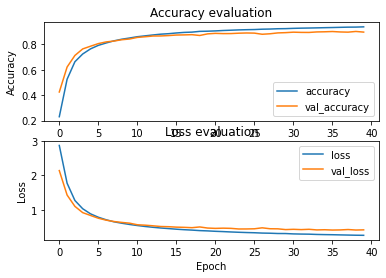

183/183 [==============================] - 0s 2ms/step - loss: 0.4210 - accuracy: 0.8960
Test erros: 0.4209633767604828,Test accuracy: 0.8959835171699524 


In [ ]:
if __name__ == "__main__":
    main()
